In [35]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import numpy as np

from glob import glob
import os

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

AUTOTUNE = tf.data.experimental.AUTOTUNE
    
print(tf.__version__)

Device: grpc://10.0.0.2:8470


2023-02-06 09:06:42.132531: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-02-06 09:06:42.132899: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2023-02-06 09:06:42.138350: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2023-02-06 09:06:42.139018: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}


Number of replicas: 8
2.4.1


# Van Gogh Me! Celebrity portraits in Van Gogh Painting Style

The model trained in this notebook generates celebrity photos in Van Gogh Painting Style. It is based on the CycleGAN architecture, which was developed for unpaired image-to-image translation tasks such as generating paintings in various artistic styles such as Monet, Van Gogh or Cezanne from photos or vice-versa, winter to summer transition in photos, etc.

The task being solved in this notebook is that of generating celebrity face portraits in Van Gogh's style of painting. 

## Dataset

We use the `Van Gogh Paintings` dataset from Kaggle, for all the van gogh paintings and the `CelebA` dataset, which contains photos of celebrity faces. This data is not paired i.e. there is no one-to-one mapping between the 2 datasets. This is a highly prevalent problem in the domain, as such datasets cannot be used to train traditional models, such as `Encoders` which could perform the image translation task. Since paired image data is hard to find, an image translation model should ideally be able to train without such data. 

## Preprocessing

We resize the images to size (128, 128) to make the training of model possible with the images using the compute power that we have. In the below cell we also view the first 100 images from each dataset.

One more decision that had been taken was that of the balancing of the dataset sizes. The datasets have been generated such that the number of images in the van gogh set are the same as that in celeb face photos set, which is 2025. This has been done to ensure that both the competing models i.e. generators and discriminators are trained with the same amount of data. Thus, ensuring both models perform similarly.

No. of Van Gogh Paintings 2025


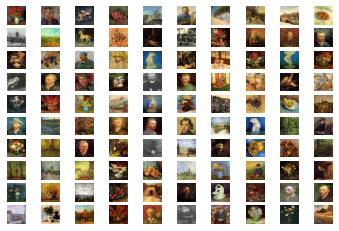

No. of Celeb Images 2026


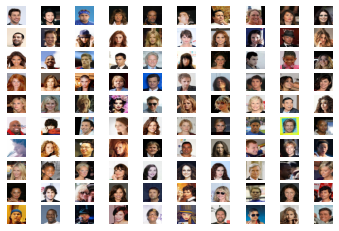

In [36]:
import cv2 as cv
IMG_DIMS = (128, 128)

# Loading Van Gogh Images
VAN_GOGH_DIR_PTH = '../input/van-gogh-paintings/VincentVanGogh'
paintings = []

j = 0
for art_type in os.listdir(VAN_GOGH_DIR_PTH):
    for art in os.listdir(VAN_GOGH_DIR_PTH + '/' + art_type):
        img = cv.imread(VAN_GOGH_DIR_PTH + '/' + art_type + '/' + art)
        img = cv.resize(img, IMG_DIMS)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        
        if j < 100:
            plt.subplot(10, 10, j + 1)
            plt.imshow(img)
            plt.axis('off')
        
        j += 1
        paintings.append(np.float32(img))

print("No. of Van Gogh Paintings", len(paintings))
plt.show()
# Loading Celeb Images
CELEB_DIR_PTH = '../input/celeba-dataset/img_align_celeba/img_align_celeba'
celeb_imgs = []

for i, img_fname in enumerate(os.listdir(CELEB_DIR_PTH)[::100]):
    img = cv.imread(CELEB_DIR_PTH + '/' + img_fname)
    img = cv.resize(img, IMG_DIMS)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    
    if i < 100:
        plt.subplot(10, 10, i + 1)
        plt.imshow(img)
        plt.axis('off')
    
    celeb_imgs.append(np.float32(img))

paintings_set = tf.data.Dataset.from_tensor_slices(paintings).batch(1)
celebs_set = tf.data.Dataset.from_tensor_slices(celeb_imgs[:-1]).batch(1)
    
print("No. of Celeb Images", len(celeb_imgs))
plt.show()    

In [37]:
print(paintings[1].shape)

(128, 128, 3)


# CycleGAN Architecture

## Recap of the GAN architecture

GAN architectures are deep neural network based architectures consisting of 2 competing models: the generator and the discriminator. These models are trained to generate illustrative images from noise. The Generator model generates an image from noise and feeds it to the discriminator model which determines, whether or not the image is 'real' in terms of the domain or not. 


In [53]:
# Generator Code
## Step 1: Down Sample the image 
## Step 2: Upsample the image using Transpose Convolution

def make_generator():
    ## Input Layer
    input_layer = layers.Input([*IMG_DIMS, 3])
    x = input_layer
#     print(x.shape)
    ## Downsampler
    skips = []
    x = layers.Conv2D(filters = 64, kernel_size = (7, 7), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 64 * 64 * 64
    skips.append(x)
#     print(x.shape)
    x = layers.Conv2D(filters = 128, kernel_size = (3, 3), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 32 * 32 * 128
    skips.append(x)
#     print(x.shape)
    x = layers.Conv2D(filters = 256, kernel_size = (3, 3), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 16 * 16 * 256
    skips.append(x)
#     print(x.shape)
    x = layers.Conv2D(filters = 512, kernel_size = (4, 4), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 8 * 8 * 512
    skips.append(x)
#     print(x.shape)
    x = layers.Conv2D(filters = 512, kernel_size = (4, 4), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 4 * 4 * 512
    skips.append(x)
#     print(x.shape)
    x = layers.Conv2D(filters = 512, kernel_size = (4, 4), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 2 * 2 * 512
    skips.append(x)
#     print(x.shape)
    x = layers.Conv2D(filters = 512, kernel_size = (4, 4), 
                      strides = 2, padding = 'same', activation = 'relu')(x) # 1 * 1 * 512
#     print(x.shape)
    
    ## Upsampling
    x = layers.Conv2DTranspose(filters = 512, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 2 * 2
    x = layers.Concatenate()([x, skips[-1]])
    x = layers.Conv2DTranspose(filters = 512, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 4 * 4
    x = layers.Concatenate()([x, skips[-2]])
    x = layers.Conv2DTranspose(filters = 512, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 8 * 8
    x = layers.Concatenate()([x, skips[-3]])
    x = layers.Conv2DTranspose(filters = 256, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 16 * 16
    x = layers.Concatenate()([x, skips[-4]])
    x = layers.Conv2DTranspose(filters = 128, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 32 * 32
    x = layers.Concatenate()([x, skips[-5]])
    x = layers.Conv2DTranspose(filters = 64, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 64 * 64
    x = layers.Concatenate()([x, skips[-6]])
    x = layers.Conv2DTranspose(filters = 3, kernel_size = (4, 4), strides = 2, 
                               padding = 'same', activation = 'relu')(x) # 128 * 128
    
    return keras.Model(inputs = input_layer, outputs = x)

In [39]:
!pip install tensorflow-addons

In [54]:
# Discrimitor

import tensorflow_addons as tfa

def make_descriminator():
    model = keras.Sequential()
    # Input Layer
    model.add(layers.Input([*IMG_DIMS, 3]))
    
    # Convolution Net
    model.add(layers.Conv2D(64, (4, 4), strides = 2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(128, (4, 4), strides = 2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(256, (4, 4), strides = 2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Conv2D(512, (4, 4), strides = 2))
    model.add(tfa.layers.InstanceNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.GlobalAveragePooling2D())
    
    # Connected Net
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(64))
    model.add(layers.LeakyReLU())
    model.add(layers.Dense(1))
    
    return model

In [55]:
gogh_generator = make_generator()
gogh_descriminator = make_descriminator()

celeb_generator = make_generator()
celeb_descriminator = make_descriminator()

In [56]:
import sys
binary_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True,
                                reduction=tf.keras.losses.Reduction.NONE)

def generator_loss(disc_op):
    return binary_cross_entropy(tf.ones_like(disc_op), disc_op)

def disc_loss(real_op, fake_op):
    return 0.5 * (binary_cross_entropy(tf.ones_like(real_op), real_op) + 
                  binary_cross_entropy(tf.zeros_like(fake_op), fake_op))

def similar_loss(real_img, similar_img, LAMBDA):
    return tf.reduce_mean(tf.abs(real_img - similar_img)) * LAMBDA

class CycleGAN(keras.Model):
    def __init__(self, lambda_cycle):
        super(CycleGAN, self).__init__()
        
        self.gogh_generator = make_generator()
        self.gogh_discriminator = make_descriminator()

        self.celeb_generator = make_generator()
        self.celeb_discriminator = make_descriminator()
        
        self.lambda_cycle = lambda_cycle
        
    def compile(self, lr):
        super(CycleGAN, self).compile()
        self.gogh_gen_opt = tf.keras.optimizers.Adam(learning_rate = lr)
        self.celeb_gen_opt = tf.keras.optimizers.Adam(learning_rate = lr)
        
        self.gogh_disc_opt = tf.keras.optimizers.Adam(learning_rate = lr)
        self.celeb_disc_opt = tf.keras.optimizers.Adam(learning_rate = lr)
        
        self.gen_loss_fn = generator_loss
        self.disc_loss_fn = disc_loss
        
        self.similar_loss_fn = similar_loss
        
    def train_step(self, batch_data):
        van_gogh, celeb = batch_data
        print(van_gogh.shape, celeb.shape)
        with tf.GradientTape(persistent = True) as tape:
            gogh_generated = self.gogh_generator(celeb, training = True)
            similar2celeb = self.celeb_generator(gogh_generated, training = True)
            
            celeb_generated = self.celeb_generator(van_gogh, training = True)
            similar2gogh = self.gogh_generator(celeb_generated, training = True)
            
            same_gogh = self.gogh_generator(van_gogh, training = True)
            same_celeb = self.celeb_generator(celeb, training = True)
            
            gogh_disc_real = self.gogh_discriminator(van_gogh, training = True)
            celeb_disc_real = self.celeb_discriminator(celeb, training = True)
            
            gogh_disc_fake = self.gogh_discriminator(gogh_generated, training = True)
            celeb_disc_fake = self.celeb_discriminator(celeb_generated, training = True)
            
            gogh_gen_loss = self.gen_loss_fn(gogh_disc_fake)
            celeb_gen_loss = self.gen_loss_fn(celeb_disc_fake)
            
            similar_loss = self.similar_loss_fn(celeb, similar2celeb, self.lambda_cycle) + self.similar_loss_fn(van_gogh, similar2gogh, self.lambda_cycle)
                
            total_gogh_loss = gogh_gen_loss + similar_loss + self.similar_loss_fn(van_gogh, same_gogh, self.lambda_cycle)
            total_celeb_loss = celeb_gen_loss + similar_loss + self.similar_loss_fn(celeb, same_celeb, self.lambda_cycle)
                
            gogh_disc_loss = self.disc_loss_fn(gogh_disc_real, gogh_disc_fake)
            celeb_disc_loss = self.disc_loss_fn(celeb_disc_real, celeb_disc_fake)
            
            # Gradient - todo
            gogh_gen_grad = tape.gradient(total_gogh_loss, self.gogh_generator.trainable_variables)
            celeb_gen_grad = tape.gradient(total_celeb_loss, self.celeb_generator.trainable_variables)
            
            gogh_disc_grad = tape.gradient(gogh_disc_loss, self.gogh_discriminator.trainable_variables)
            celeb_disc_grad = tape.gradient(celeb_disc_loss, self.celeb_discriminator.trainable_variables)
            
            self.gogh_gen_opt.apply_gradients(
                zip(gogh_gen_grad, self.gogh_generator.trainable_variables)
            )
            self.celeb_gen_opt.apply_gradients(
                zip(celeb_gen_grad, self.celeb_generator.trainable_variables)
            )
            
            self.gogh_disc_opt.apply_gradients(
                zip(gogh_disc_grad, self.gogh_discriminator.trainable_variables)
            )
            self.celeb_disc_opt.apply_gradients(
                zip(celeb_disc_grad, self.celeb_discriminator.trainable_variables)
            )
            
            return {
                "painting_gen_loss": total_gogh_loss,
                "celeb_gen_loss": total_celeb_loss,
                "gogh_disc_loss": gogh_disc_loss,
                "celeb_disc_loss": celeb_disc_loss
            }

In [57]:
model = CycleGAN(lambda_cycle = 10)
model.compile(0.0001)

In [ ]:
model.fit(tf.data.Dataset.zip((paintings_set, celebs_set)), epochs = 3)

Epoch 1/3
(None, 128, 128, 3) (None, 128, 128, 3)
(None, 128, 128, 3) (None, 128, 128, 3)
2025/2025 [==============================] - 497s 240ms/step - painting_gen_loss: 502.1027 - celeb_gen_loss: 416.0345 - gogh_disc_loss: 0.1752 - celeb_disc_loss: 0.2813
Epoch 2/3
1413/2025 [===================>..........] - ETA: 2:27 - painting_gen_loss: 336.4163 - celeb_gen_loss: 260.5500 - gogh_disc_loss: 0.0921 - celeb_disc_loss: 0.1387

In [ ]:
plt.imshow(celeb_imgs[0].astype(np.uint8))

In [ ]:
plt.imshow(celeb_imgs[0].astype(np.uint8))
prediction = model.gogh_generator(celeb_imgs[0][None, :, :, :], training = False)[0].numpy()
prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
plt.imshow(prediction)